In [97]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy import stats
from scipy.stats import chi2_contingency

##ABtest_data

サイトの収入を増やすために A/B テストを開始しました。 
Excel ファイルには、実験の結果 (userid)、サンプルの種類 
(variantname)、およびユーザーがもたらした収入(revenue) に関する生データが含まれています。 タスクは、実験の結果を分析し、推奨事項を作成することです。

In [2]:
#データの読み込み
df = pd.read_csv("AB_Test_Results.csv")

In [3]:
#データの確認
print(df.shape)
df.head(3)

(10000, 3)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0


In [12]:
#欠損値の確認
df.isnull().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [13]:
#データ型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [14]:
#基本統計量
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


##基本情報確認

In [7]:
#control、variantの数を確認
df["VARIANT_NAME"].value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [9]:
#user_id数の確認
df["USER_ID"].unique().shape

(6324,)

In [10]:
df["REVENUE"].value_counts()

0.00     9848
1.25       10
3.25        6
1.01        6
0.04        5
         ... 
17.05       1
8.70        1
3.79        1
1.92        1
3.58        1
Name: REVENUE, Length: 101, dtype: int64

・control、variantは半々で分かれている

・ユーザーIDを見ると同じIDの人が3,700人ほどいる

・収益はほとんどが0

In [22]:
#ダブっているユーザーをみてみる
tmp = df.groupby("USER_ID").agg({"VARIANT_NAME":"count"}).reset_index().rename(columns={"VARIANT_NAME":"size"}) #ユーザー毎に出現回数をカウント
tmp = tmp[tmp["size"]>1] #出現回数が２回以上のユーザーを抽出
tmp = pd.merge(df,tmp,on="USER_ID",how="inner") #2回目以上のユーザーデータセットを作成
tmp.head()

,USER_ID,VARIANT_NAME,REVENUE,size
0,737,variant,0.0,2
1,737,variant,0.0,2
2,2423,control,0.0,3
3,2423,control,0.0,3
4,2423,variant,0.0,3


In [25]:
#control、variant毎にユーザー数を確認
tmp.groupby(["VARIANT_NAME"]).agg({"size":"count"})

,size
VARIANT_NAME,
control,3150
variant,3186


In [41]:
#同じユーザーの出現回数を確認
print(tmp["size"].value_counts())
print(tmp["size"].value_counts().sum())

2    3780
3    1710
4     636
5     180
6      30
Name: size, dtype: int64
6336


In [45]:
#control、variantどちらにも属しているユーザー数の確認
tmp.groupby(["USER_ID"])["VARIANT_NAME"].nunique().value_counts()

2    1541
1    1119
Name: VARIANT_NAME, dtype: int64

control、variantどちらにも属するユーザーが1,541人(24.3%)存在することがわかった。また、同一群内に複数回来ているユーザーが各群毎に約6割存在することがわかった。

In [54]:
#control、variantどちらにも属するユーザーを除外
user = df.groupby("USER_ID")["VARIANT_NAME"].nunique() == 1 #ダブっていないユーザーIDを抽出
users = user[user] #Trueのユーザーのみ抽出

In [59]:
#ダブってないユーザーのみ出力したリストを作成
df_1 = df[df["USER_ID"].isin(users.index)]

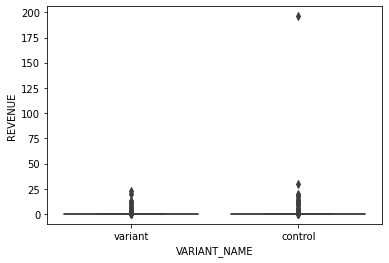

In [62]:
#REVENUEの箱ひげ図作成
sns.boxplot(data=df_1, x="VARIANT_NAME", y="REVENUE")

他と比べて値が大きすぎるユーザーがいる。
REVENUEが100以上の件数を調べて少ないようだったら外れ値として除外する

In [64]:
#ソートしてREVERUE１００以上が何人いるか確認
df_1.sort_values(by="REVENUE",ascending=False)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
...,...,...,...
3366,1189,control,0.00
3363,2051,variant,0.00
3362,3276,variant,0.00
3360,1608,variant,0.00


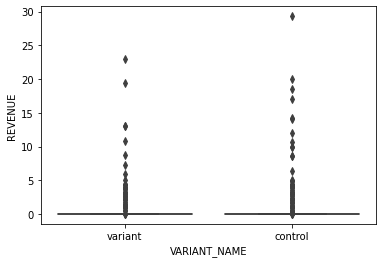

In [68]:
#外れ値を除外して再度箱ひげ図を作成
df_1 = df_1[df_1["REVENUE"]<100] #外れ値を除外
sns.boxplot(data=df_1, x="VARIANT_NAME", y="REVENUE")

ほとんどが0
介入群の方が若干収益が高いか
同一グループ内で複数サイトに訪れている人が各グループに６割ほどいたため複数来訪しているユーザーが０を多くしている可能性がある

In [71]:
#ユーザー毎に１行のテーブルを作成
print(df_1["USER_ID"].nunique()) #ユーザー数の確認
df_2 = df_1.groupby(["USER_ID","VARIANT_NAME"]).agg({"REVENUE":"sum"}).reset_index()
print(df_2["USER_ID"].nunique()) #結合後のユーザー数の確認

4782
4782


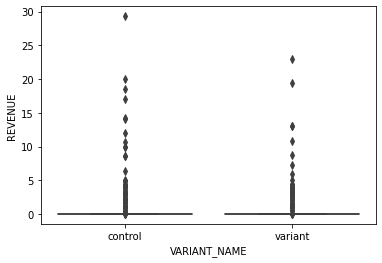

In [72]:
#箱ひげ図を作成
sns.boxplot(data=df_2, x="VARIANT_NAME", y="REVENUE")

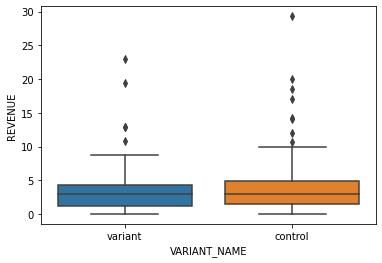

In [73]:
#変わらないためREVENUE>0でみてみる
sns.boxplot(data=df_2[df_2["REVENUE"]>0], x="VARIANT_NAME", y="REVENUE")

介入群の方が若干箱が大きくなっている。

７５％以上のユーザー数も多い。

In [77]:
#ユーザー数をカウント
test = df_2.groupby("VARIANT_NAME").agg({"USER_ID":"count"}).reset_index()
test

,VARIANT_NAME,USER_ID
0,control,2389
1,variant,2393


In [78]:
#REVENUEが０以外のユーザー数カウント
test_revenue = df_2[df_2["REVENUE"]>0].groupby("VARIANT_NAME").agg({"USER_ID":"count"}).reset_index()
test_revenue

,VARIANT_NAME,USER_ID
0,control,53
1,variant,42


In [79]:
#REVERUEの合計値
test_sum_revenue = df_2.groupby("VARIANT_NAME").agg({"REVENUE":"sum"}).reset_index()
test_sum_revenue

,VARIANT_NAME,REVENUE
0,control,274.55
1,variant,179.32


In [87]:
#データを結合
test_data = pd.merge(test, test_revenue, on="VARIANT_NAME", how="inner")

In [88]:
#revenueに繋がらなかったユーザー数を算出
test_data["no revenue"] = test_data["USER_ID_x"] - test_data["USER_ID_y"]
test_data

,VARIANT_NAME,USER_ID_x,USER_ID_y,no revenue
0,control,2389,53,2336
1,variant,2393,42,2351


In [94]:
#カラム名を変更
test_data.rename(columns={"USER_ID_y":"revenue"},inplace=True)
#USER_ID_xを削除
test_data.drop("USER_ID_x", axis=1, inplace=True)

In [95]:
test_data

,VARIANT_NAME,revenue,no revenue
0,control,53,2336
1,variant,42,2351


検定を行うにあたり仮説設定

・帰無仮説　variantとcontrolのrevenue数は同じ(control=variant)

・対立仮説　variantはcontrolよりrevenur数が多い(control<variant)

・有意水準5%のカイ二乗検定

In [99]:
#検定用データを作成
test_1 = pd.DataFrame([[53,2336], [42,2351]])

#カイ二乗検定 今回イェーツの補正はFalse
chi2, p, dof, expected = chi2_contingency(test_1, correction=False)

In [100]:
#結果の確認
print("カイ二乗値:", chi2)
print("p値:", p)
print("自由度:", dof)
print("期待度数:", expected)

カイ二乗値: 1.3183443731098519
p値: 0.25088940020869427
自由度: 1
期待度数: [[  47.46026767 2341.53973233]
 [  47.53973233 2345.46026767]]


カイ二乗値が1.32と自由度１のカイ二乗分布(0.05)は3.84と５％検定で帰無仮説を棄却できない。

そのため100回中95回以内に同様の事象は起こり得ると判断できる。

今回の検定結果からcontrolとvariantにおけるrevenur数において有意な差は見られなかった。

In [102]:
#revenue額の検定
variant = df_2[df_2["VARIANT_NAME"]=="variant"]["REVENUE"] #対照群
control = df_2[df_2["VARIANT_NAME"]=="control"]["REVENUE"] #介入群

In [110]:
#統計量の確認
print("variant_mean:", variant.mean())
print("control_mean:", control.mean())
print("variant_mean - control_mean:", variant.mean() - control.mean())

print("-"*50)

print("variant_std:", variant.std(ddof=1))
print("control_std:", control.std(ddof=1))

variant_mean: 0.07493522774759716
control_mean: 0.11492256174131439
variant_mean - control_mean: -0.03998733399371723
--------------------------------------------------
variant_std: 0.8582073793203311
control_std: 1.162494594046206


平均はcontrolが0.04高い。
不変標準偏差も平均と同様にcontrol群が高い

(array([18., 15.,  2.,  2.,  1.,  2.,  0.,  0.,  1.,  1.]),
 array([2.0000e-02, 2.3220e+00, 4.6240e+00, 6.9260e+00, 9.2280e+00,
        1.1530e+01, 1.3832e+01, 1.6134e+01, 1.8436e+01, 2.0738e+01,
        2.3040e+01]),
 <a list of 10 Patch objects>)

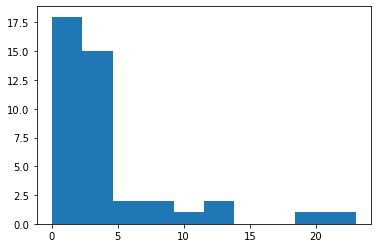

In [122]:
#正規分布の確認
a = variant > 0 #variantが0以外を抽出
a = a[a]
a = variant[a.index]

plt.hist(a,bins=10) #ヒストグラム描画

F検定を行い分散に差がないことを検定する

有意水準は0.05とする

In [127]:
v_var = np.var(variant, ddof=1) #variant不変分散
c_var = np.var(control, ddof=1) #control不変分散
v_df = len(variant) #variant自由度
c_df = len(control) #controlの自由度
f = v_var / c_var #F比の値
pval1 = stats.f.cdf(f, v_df, c_df) #片側検定
pval2 = stats.f.sf(f, v_df, c_df) #片側検定
two_pval = min(pval1, pval2)*2 #両側検定

print("F値:", f)
print("two_pval:", two_pval)

F値: 0.5450076585182311
two_pval: 4.291830878193023e-49


２群はp < 0.05であり、帰無仮説は棄却された

中央値に差があるかの検定を行う

・帰無仮説　中央値に差がない

・対立仮説　中央値に差がある

ウィルコクソンの順位和検定 有意水準0.05

In [128]:
#ウィルコクソンの順位和検定
stats.mannwhitneyu(variant, control, alternative='two-sided')

MannwhitneyuResult(statistic=2845109.0, pvalue=0.24799555106821958)

p値は0.27と0.05より大きいため有意水準0.05%で帰無仮説を棄却できない

In [130]:
#ちなみにrevenueが０を抜くと
a = variant > 0 #variantが0以外を抽出
a = a[a]
a = variant[a.index]

b = control > 0
b = b[b]
b = control[b.index]

stats.mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=1029.0, pvalue=0.5314192217084708)

0を除いてもp値は0.5と帰無仮説を有意水準0.05%で棄却できない

今回のABテストでは統計的に有意な差は見られなかった。
そのため、今回の変更は収益に影響を及ぼさないため別の変更を検討する必要がある。